In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as f
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

In [ ]:
# Install torchinfo if it's not available, import it if it is
try:
    from torchinfo import summary
except:
    !pip install torchinfo
    import torchinfo

In [ ]:
# Install the Kaggle API package to enable downloading datasets from Kaggle
!pip install kaggle

In [ ]:
# Import the drive module from Google Colab
from google.colab import drive

# Mount Google Drive to the Colab environment at the specified path
# This allows you to access files stored in your Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir drive/MyDrive/DL_projects_colab/pytorch_datasets/

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# Define the Kaggle API token with your username and key ---> Please define your 'username' and 'key' in your api_token
api_token = {"username":"------","key":"------"}

import json

# Save the Kaggle API token to a file in the default location for Kaggle credentials
# This file will be used by the Kaggle API to authenticate requests
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

    # Set file permissions to be readable and writable only by the owner
    # This ensures that the API token is secure and not accessible by other users
    !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the specified dataset from Kaggle using the Kaggle API
# The dataset is identified by its unique dataset URL path
!kaggle datasets download -d phylake1337/fire-dataset

Dataset URL: https://www.kaggle.com/datasets/phylake1337/fire-dataset
License(s): CC0-1.0
100% 387M/387M [00:23<00:00, 18.9MB/s]
100% 387M/387M [00:23<00:00, 17.6MB/s]


In [ ]:
!unzip -q fire-dataset.zip

In [ ]:
import os

# Get the current working directory
current_path = os.getcwd()

# Print the current working directory
print("Current working directory:", current_path)

Current working directory: /content


In [ ]:
# Change to a specific directory
%cd /content/drive/MyDrive/DL_projects_colab/pytorch_datasets/fire_dataset

/content/drive/MyDrive/DL_projects_colab/pytorch_datasets/fire_dataset


In [ ]:
image_path = os.path.join(os.getcwd())
image_path

'/content/drive/MyDrive/DL_projects_colab/pytorch_datasets/fire_dataset'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
walk_through_dir(image_path)

There are 4 directories and 0 images in '/content/drive/MyDrive/DL_projects_colab/pytorch_datasets/fire_dataset'.
There are 0 directories and 0 images in '/content/drive/MyDrive/DL_projects_colab/pytorch_datasets/fire_dataset/fire'.
There are 0 directories and 0 images in '/content/drive/MyDrive/DL_projects_colab/pytorch_datasets/fire_dataset/non_fire'.
There are 2 directories and 0 images in '/content/drive/MyDrive/DL_projects_colab/pytorch_datasets/fire_dataset/train'.
There are 0 directories and 566 images in '/content/drive/MyDrive/DL_projects_colab/pytorch_datasets/fire_dataset/train/fire'.
There are 0 directories and 183 images in '/content/drive/MyDrive/DL_projects_colab/pytorch_datasets/fire_dataset/train/non_fire'.
There are 2 directories and 0 images in '/content/drive/MyDrive/DL_projects_colab/pytorch_datasets/fire_dataset/test'.
There are 0 directories and 189 images in '/content/drive/MyDrive/DL_projects_colab/pytorch_datasets/fire_dataset/test/fire'.
There are 0 directori

# Visualize an image

Random image path: /content/drive/MyDrive/DL_projects_colab/pytorch_datasets/fire_dataset/train/fire/fire.16.png
Image class: fire
Image height: 720
Image width: 1280


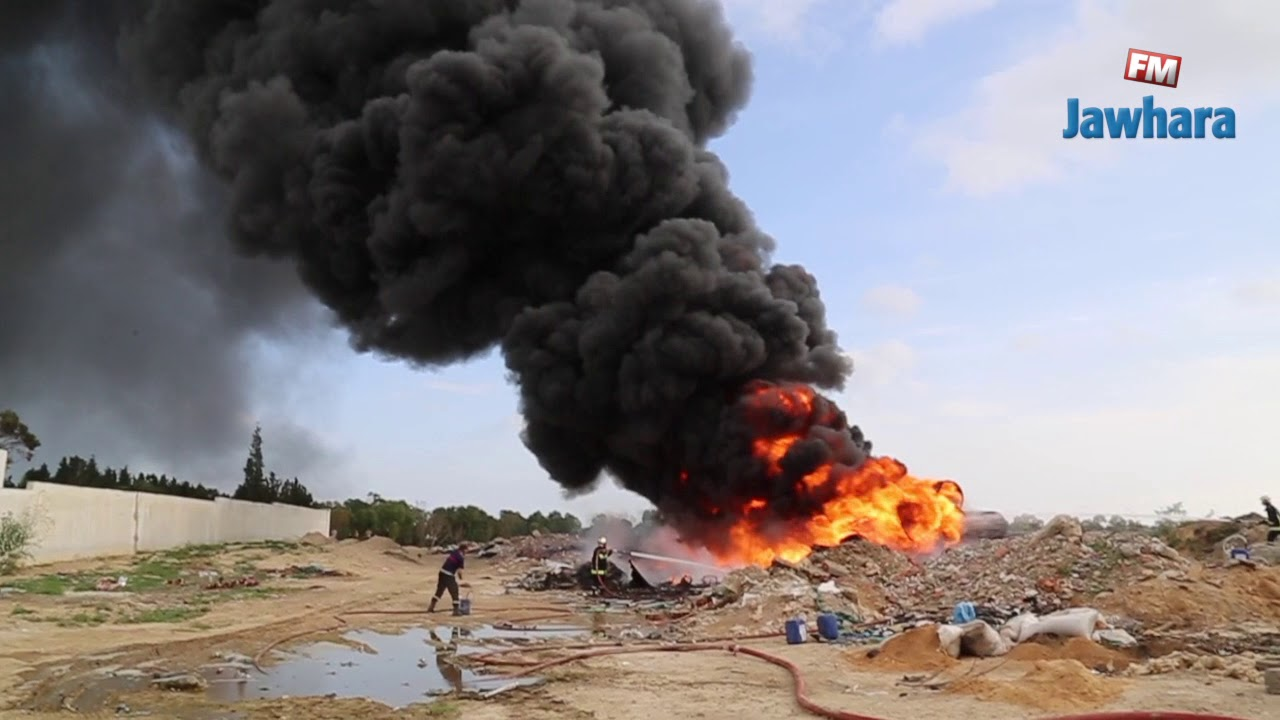

In [ ]:
import random
from PIL import Image

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.*.png"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

# Splitting Data into Training and Test Dataset Folders

In [ ]:
current_dir = os.getcwd()
train_dir = os.path.join(current_dir, "train")
test_dir = os.path.join(current_dir, "test")

In [ ]:
# Create target directories if they do not exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [ ]:
from sklearn.model_selection import train_test_split
import shutil
from pathlib import Path

# Define target directories using pathlib
current_dir = Path.cwd()
fire_images_dir = current_dir / "fire"
non_fire_images_dir = current_dir / "non_fire"


def split_and_move_images(source_dir, train_dir, test_dir, test_size=0.25):
    # List all files in the source directory
    all_images = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]

    # Split images into train and test sets
    train_files, test_files = train_test_split(all_images, test_size=test_size, random_state=42)

    # Move training images
    for file_name in train_files:
        shutil.move(os.path.join(source_dir, file_name), os.path.join(train_dir, file_name))

    # Move testing images
    for file_name in test_files:
        shutil.move(os.path.join(source_dir, file_name), os.path.join(test_dir, file_name))

In [ ]:
fire_images_dir

PosixPath('/content/drive/MyDrive/DL_projects_colab/pytorch_datasets/fire_dataset/fire')

In [ ]:
# Split and move fire images
split_and_move_images(fire_images_dir, os.path.join(train_dir, 'fire'), os.path.join(test_dir, 'fire'))

# Split and move non-fire images
split_and_move_images(non_fire_images_dir, os.path.join(train_dir, 'non_fire'), os.path.join(test_dir, 'non_fire'))

print("Dataset splitting and moving complete.")

Dataset splitting and moving complete.


In [ ]:
walk_through_dir(image_path)

There are 5 directories and 0 images in '/content/drive/MyDrive/DL_projects_colab/pytorch_datasets/fire_dataset'.
There are 0 directories and 0 images in '/content/drive/MyDrive/DL_projects_colab/pytorch_datasets/fire_dataset/fire'.
There are 0 directories and 0 images in '/content/drive/MyDrive/DL_projects_colab/pytorch_datasets/fire_dataset/non_fire'.
There are 0 directories and 0 images in '/content/drive/MyDrive/DL_projects_colab/pytorch_datasets/fire_dataset/.ipynb_checkpoints'.
There are 3 directories and 0 images in '/content/drive/MyDrive/DL_projects_colab/pytorch_datasets/fire_dataset/train'.
There are 0 directories and 566 images in '/content/drive/MyDrive/DL_projects_colab/pytorch_datasets/fire_dataset/train/fire'.
There are 0 directories and 0 images in '/content/drive/MyDrive/DL_projects_colab/pytorch_datasets/fire_dataset/train/.ipynb_checkpoints'.
There are 0 directories and 183 images in '/content/drive/MyDrive/DL_projects_colab/pytorch_datasets/fire_dataset/train/non_f

In [ ]:
image_path = Path(current_dir)

# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('/content/drive/MyDrive/DL_projects_colab/pytorch_datasets/fire_dataset/train'),
 PosixPath('/content/drive/MyDrive/DL_projects_colab/pytorch_datasets/fire_dataset/test'))

# Transforming data with `torchvision.transforms`

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

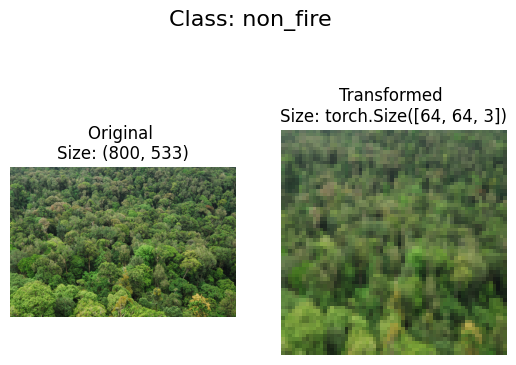

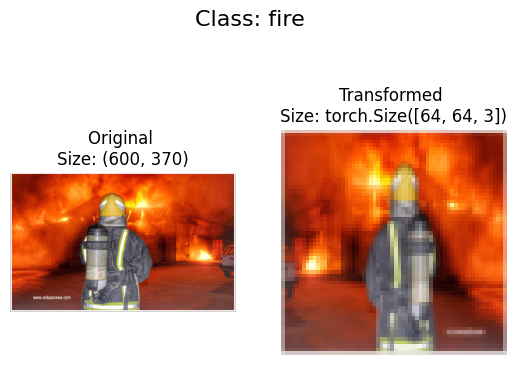

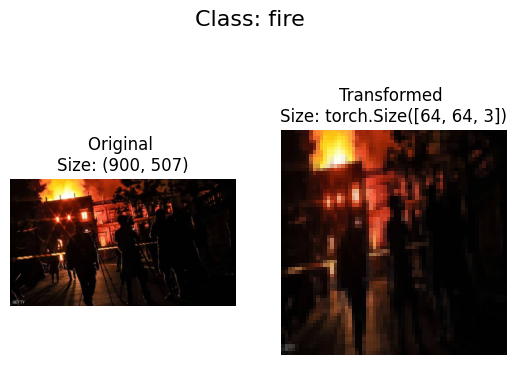

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

image_path_list_2 = list(image_path.glob("*/*/*.*.png"))
plot_transformed_images(image_path_list_2,
                        transform=data_transform,
                        n=3)

# Loading Image Data Using `ImageFolder`

In [ ]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 749
    Root location: /content/drive/MyDrive/DL_projects_colab/pytorch_datasets/fire_dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 250
    Root location: /content/drive/MyDrive/DL_projects_colab/pytorch_datasets/fire_dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [ ]:
# Get class names as a list
class_names = train_data.classes
class_names

['fire', 'non_fire']

In [ ]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'fire': 0, 'non_fire': 1}

In [ ]:
# Check the lengths
len(train_data), len(test_data)

(749, 250)

In [ ]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.6627, 0.6549, 0.6275,  ..., 0.7961, 0.8039, 0.8000],
         [0.6549, 0.6392, 0.6196,  ..., 0.7961, 0.8000, 0.8000],
         [0.6392, 0.6314, 0.6196,  ..., 0.7882, 0.7922, 0.7961],
         ...,
         [0.3490, 0.3255, 0.2667,  ..., 0.2510, 0.2510, 0.2510],
         [0.3569, 0.4196, 0.2745,  ..., 0.2627, 0.2941, 0.2549],
         [0.3294, 0.3843, 0.2784,  ..., 0.2706, 0.2824, 0.2941]],

        [[0.6353, 0.6314, 0.6078,  ..., 0.8078, 0.8196, 0.8157],
         [0.6314, 0.6157, 0.5961,  ..., 0.8118, 0.8157, 0.8157],
         [0.6196, 0.6157, 0.6039,  ..., 0.8078, 0.8078, 0.8078],
         ...,
         [0.2824, 0.2627, 0.2196,  ..., 0.2196, 0.2275, 0.2275],
         [0.2706, 0.3216, 0.2196,  ..., 0.2314, 0.2549, 0.2157],
         [0.2510, 0.2863, 0.2196,  ..., 0.2314, 0.2392, 0.2314]],

        [[0.5843, 0.5804, 0.5569,  ..., 0.8039, 0.8196, 0.8118],
         [0.5765, 0.5647, 0.5412,  ..., 0.8118, 0.8157, 0.8118],
         [0.5686, 0.5608, 0.5529,  ..., 0.80

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


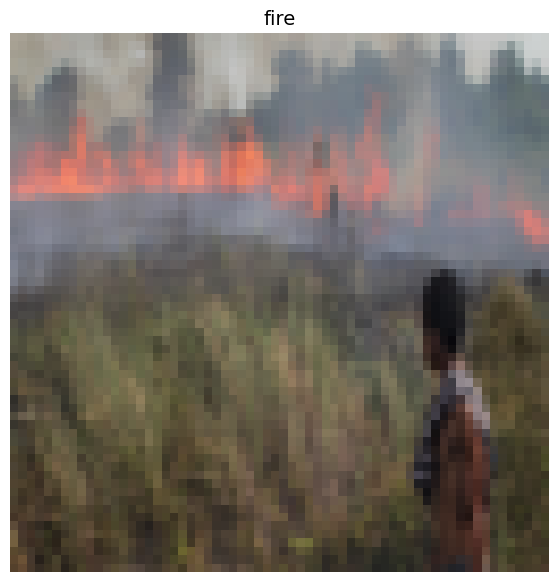

In [ ]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

# Turn loaded images into `DataLoader`

In [ ]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7e01bbdf9060>,
 <torch.utils.data.dataloader.DataLoader at 0x7e029e2454b0>)

# Model 0: TinyVGG with data augmentation (Creating TinyVGG model class)

In [ ]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=2, bias=True)
  )
)

# Performing a Forward Pass on a Single Image (Testing the Model)

In [ ]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_augmented))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0466, 0.0518]])

Output prediction probabilities:
tensor([[0.4987, 0.5013]])

Output prediction label:
tensor([1])

Actual label:
0


# Using `torchinfo` to Examine the Tensor Shapes Passing Through Our Model

In [ ]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 2]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

# Creating Training and Testing Loop Functions

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

# Creating a `train()` Function to Integrate `train_step()` and `test_step()`

In [ ]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

# Training and Evaluating Model 0

In [ ]:
# Set number of epochs
NUM_EPOCHS = 25

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5671 | train_acc: 0.7333 | test_loss: 0.5471 | test_acc: 0.7383
Epoch: 2 | train_loss: 0.4539 | train_acc: 0.7579 | test_loss: 0.3583 | test_acc: 0.7383
Epoch: 3 | train_loss: 0.3300 | train_acc: 0.8335 | test_loss: 0.2328 | test_acc: 0.9318
Epoch: 4 | train_loss: 0.2537 | train_acc: 0.8984 | test_loss: 0.1718 | test_acc: 0.9678
Epoch: 5 | train_loss: 0.1888 | train_acc: 0.9252 | test_loss: 0.1609 | test_acc: 0.9600
Epoch: 6 | train_loss: 0.1697 | train_acc: 0.9388 | test_loss: 0.1101 | test_acc: 0.9678
Epoch: 7 | train_loss: 0.1288 | train_acc: 0.9479 | test_loss: 0.1053 | test_acc: 0.9648
Epoch: 8 | train_loss: 0.1384 | train_acc: 0.9401 | test_loss: 0.0955 | test_acc: 0.9718
Epoch: 9 | train_loss: 0.1180 | train_acc: 0.9622 | test_loss: 0.0975 | test_acc: 0.9718
Epoch: 10 | train_loss: 0.1286 | train_acc: 0.9570 | test_loss: 0.0968 | test_acc: 0.9678
Epoch: 11 | train_loss: 0.1058 | train_acc: 0.9648 | test_loss: 0.1137 | test_acc: 0.9582
Epoch: 12 | train_l

# Plotting the Loss Curves for Model 0

In [ ]:
from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

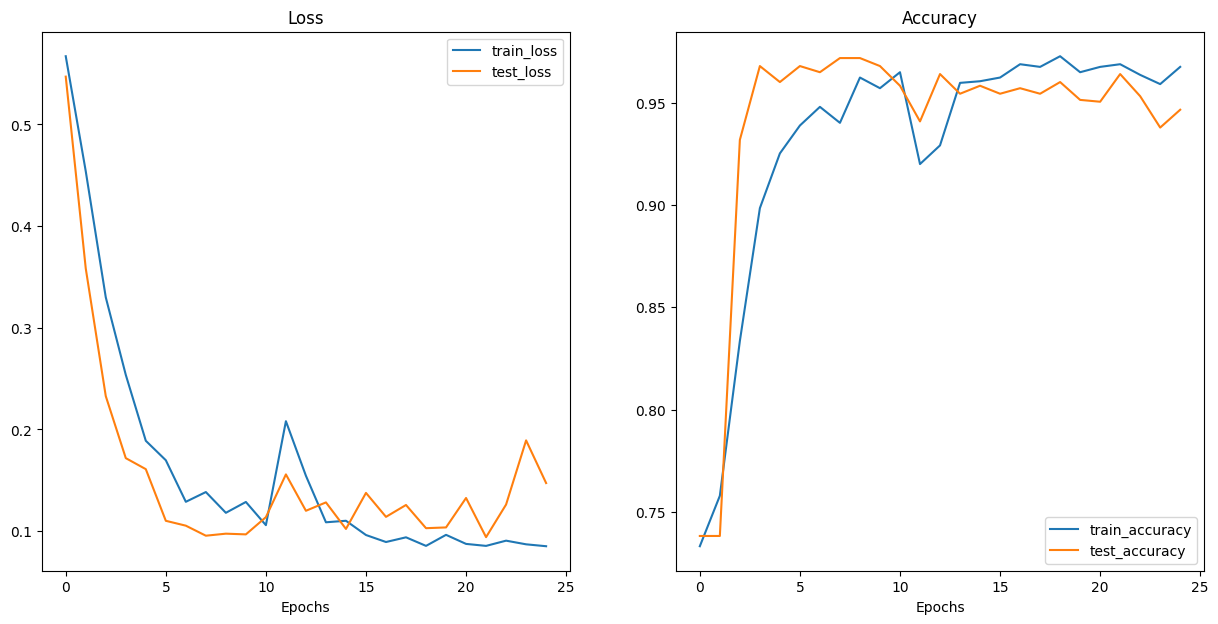

In [ ]:
plot_loss_curves(model_0_results)

In [ ]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,0.567141,0.733273,0.547064,0.738281
1,0.453934,0.757913,0.358325,0.738281
2,0.329951,0.833534,0.232766,0.931791
3,0.253672,0.898438,0.171765,0.967849
4,0.188829,0.925180,0.160921,0.960036
5,0.169694,0.938802,0.110115,0.967849
6,0.128810,0.947917,0.105319,0.964844
7,0.138403,0.940104,0.095458,0.971755
8,0.117981,0.962240,0.097454,0.971755
9,0.128648,0.957031,0.096759,0.967849


# Model Performance Across Epochs

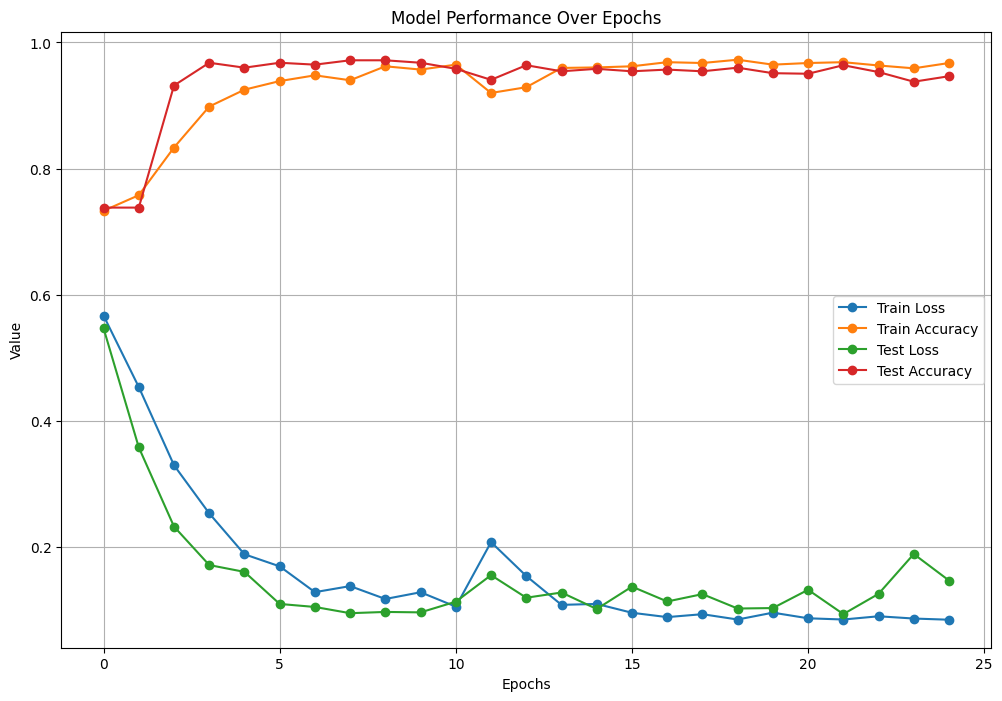

In [ ]:
# Plotting
plt.figure(figsize=(12, 8))

# Plot training loss and accuracy
plt.plot(model_0_df.index, model_0_df['train_loss'], label='Train Loss', marker='o')
plt.plot(model_0_df.index, model_0_df['train_acc'], label='Train Accuracy', marker='o')

# Plot testing loss and accuracy
plt.plot(model_0_df.index, model_0_df['test_loss'], label='Test Loss', marker='o')
plt.plot(model_0_df.index, model_0_df['test_acc'], label='Test Accuracy', marker='o')

# Adding titles and labels
plt.title('Model Performance Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')

# Adding grid
plt.grid(True)

# Adding legend
plt.legend()

# Show the plot
plt.show()

# Rate Analysis

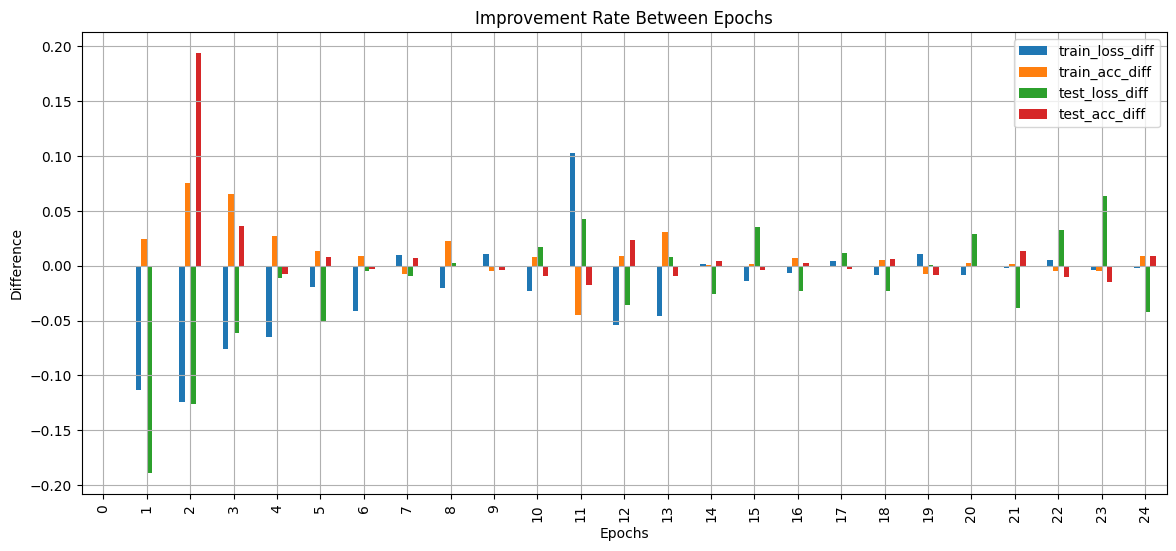

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate differences between successive epochs for training and testing metrics
model_0_df['train_loss_diff'] = model_0_df['train_loss'].diff()
model_0_df['train_acc_diff'] = model_0_df['train_acc'].diff()
model_0_df['test_loss_diff'] = model_0_df['test_loss'].diff()
model_0_df['test_acc_diff'] = model_0_df['test_acc'].diff()

# Plotting improvement rates
model_0_df[['train_loss_diff', 'train_acc_diff', 'test_loss_diff', 'test_acc_diff']].plot(kind='bar', figsize=(14, 6))

# Add title and labels
plt.title('Improvement Rate Between Epochs')
plt.ylabel('Difference')
plt.xlabel('Epochs')

# Add grid for better readability
plt.grid(True)

# Display the plot
plt.show()

# Gap Analysis

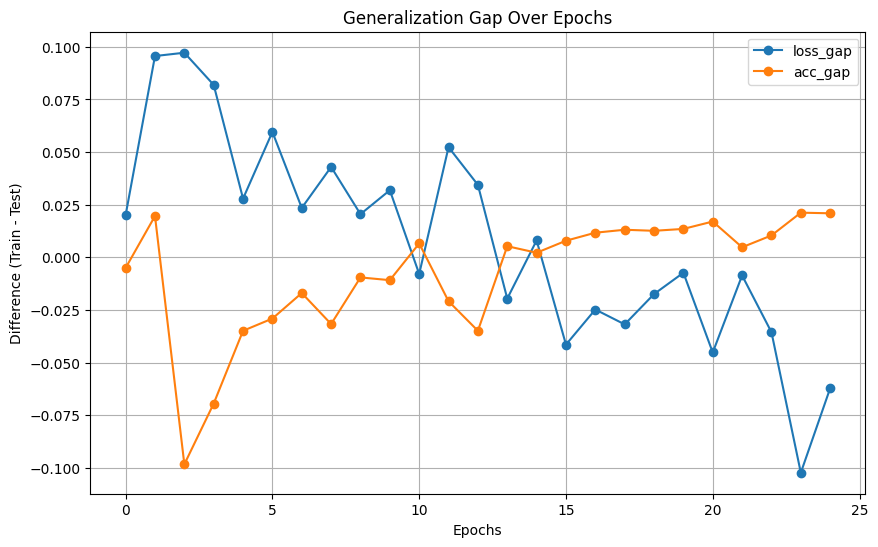

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the generalization gap (difference between training and testing metrics)
model_0_df['loss_gap'] = model_0_df['train_loss'] - model_0_df['test_loss']
model_0_df['acc_gap'] = model_0_df['train_acc'] - model_0_df['test_acc']

# Plotting generalization gap
model_0_df[['loss_gap', 'acc_gap']].plot(figsize=(10, 6), marker='o')

# Add title and labels
plt.title('Generalization Gap Over Epochs')
plt.ylabel('Difference (Train - Test)')
plt.xlabel('Epochs')

# Add grid for better readability
plt.grid(True)

# Display the plot
plt.show()

# Saving the best-performing model

In [ ]:
from pathlib import Path

BASE_PATH = Path("/content/drive/MyDrive/DL_projects_colab/pytorch_datasets")
# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = BASE_PATH / "models"
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "pytorch_fire_classification_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: /content/drive/MyDrive/DL_projects_colab/pytorch_datasets/models/pytorch_fire_classification_model_0.pth


In [ ]:
image_path

PosixPath('/content/drive/MyDrive/DL_projects_colab/pytorch_datasets/fire_dataset')

# Making Predictions on Custom Images with the Trained PyTorch Model (Image 1)

In [ ]:
import torchvision

custom_path = Path("/content/drive/MyDrive/DL_projects_colab/pytorch_datasets")
custom_image_path = Path( custom_path/"105.jpg")

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[ 20,  19,  12,  ...,  67,  74,  82],
         [ 17,  18,  16,  ...,  70,  63,  38],
         [ 18,  17,  17,  ...,  61,  51,  41],
         ...,
         [ 28,  28,  27,  ...,  34,  41,  35],
         [ 29,  29,  28,  ...,  35,  46,  75],
         [ 29,  28,  28,  ...,  41,  49, 110]],

        [[ 21,  20,  13,  ...,  76,  85,  93],
         [ 18,  19,  17,  ...,  83,  76,  53],
         [ 19,  18,  18,  ...,  80,  69,  62],
         ...,
         [ 29,  29,  28,  ...,  53,  61,  55],
         [ 30,  30,  29,  ...,  50,  60,  91],
         [ 30,  29,  29,  ...,  46,  53, 116]],

        [[ 15,  14,   8,  ...,  59,  68,  76],
         [ 12,  13,  12,  ...,  65,  59,  34],
         [ 13,  12,  13,  ...,  61,  53,  43],
         ...,
         [ 24,  24,  23,  ...,  31,  36,  30],
         [ 25,  25,  24,  ...,  27,  35,  64],
         [ 25,  24,  24,  ...,  24,  28,  90]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 575, 564])

Custom image dtype

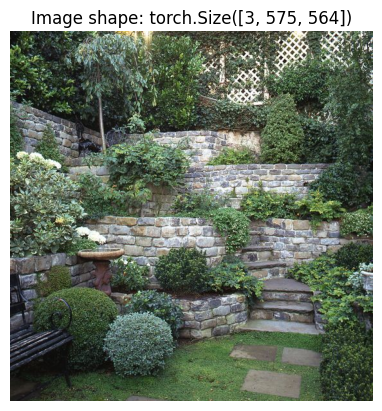

In [ ]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [ ]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 575, 564])
New shape: torch.Size([3, 64, 64])


In [ ]:
model_0.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

    # Make a prediction on image with an extra dimension
    custom_image_pred = model_0(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


In [ ]:
custom_image_pred

tensor([[-1.1016,  1.0436]])

In [ ]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[-1.1016,  1.0436]])
Prediction probabilities: tensor([[0.1048, 0.8952]])
Prediction label: tensor([1])


In [ ]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'non_fire'

In [ ]:
from typing import List, Optional

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

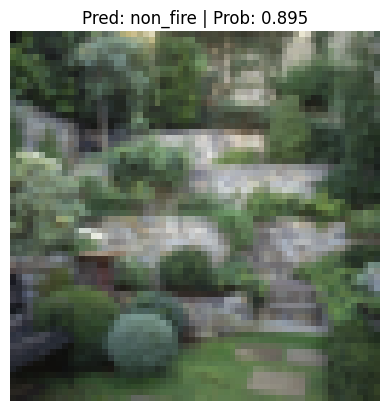

In [ ]:
# Pred on our custom image
pred_and_plot_image(model=model_0,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

# Making Predictions on Custom Images with the Trained PyTorch Model (Image 2)

In [ ]:
import torchvision

custom_path = Path("/content/drive/MyDrive/DL_projects_colab/pytorch_datasets")
custom_image_path_2 = Path( custom_path/"100.jpg")

# Read in custom image
custom_image_uint8_2 = torchvision.io.read_image(str(custom_image_path_2))

# Load in custom image and convert the tensor values to float32
custom_image_2 = torchvision.io.read_image(str(custom_image_path_2)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image_2 = custom_image_2 / 255.

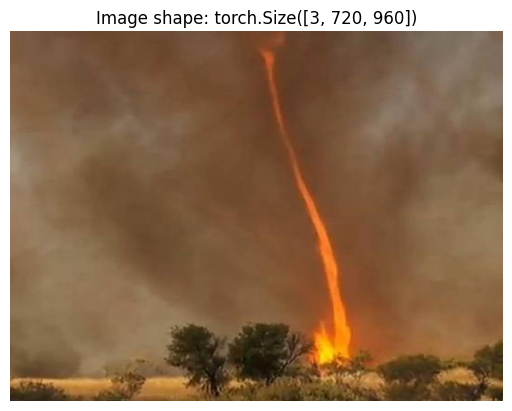

In [ ]:
# Plot custom image 2
plt.imshow(custom_image_2.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image_2.shape}")
plt.axis(False);

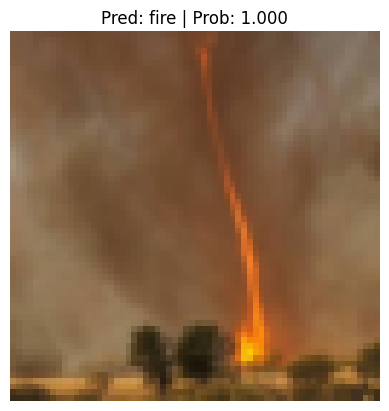

In [ ]:
# Pred on our custom image
pred_and_plot_image(model=model_0,
                    image_path=custom_image_path_2,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)